In [2]:
import simi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer, util as stu
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import torch
from tqdm.auto import tqdm, trange
tqdm.pandas()

RANDOM_STATE = 1

random.seed(RANDOM_STATE)

2023-12-15 14:34:26.553172: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
%%time
df = pd.read_pickle("zbmath-embeddings-2000-2019-multi.pkl")
df.sample(5)

CPU times: user 32.5 s, sys: 25.8 s, total: 58.3 s
Wall time: 1min 18s


,title,MSC,MSC2,embedding (Bert+mp+ret_class-zbm),embedding (Bert+mlm+mp+ret_class-zbm),embedding (Bert+tsdae-zbm+mp+ret_class-zbm_anch-arx),embedding (Bert+tsdae-arx+mp+ret_class-zbm_anch-arx),embedding (Bert+mlm+mp+ret_anch-arx_class-zbm),embedding (Mathbert+mp+ret_class-zbm),embedding (SBert+ret_class-zbm),embedding (Specter 2.0+mp+class-zbm),embedding (Specter 2.0+mp+anch-arx),embedding (SGPT+class-zbm)
3940,Hybrid algorithms for cyclically reduced conve...,65N06,"('35J25', '65Y20')","[-0.1437272, 0.42241278, -0.5664936, 0.0047696...","[0.87835455, 1.0313822, -0.03918722, -0.740078...","[-0.33746767, -0.0015559396, 0.20995729, 0.079...","[-0.15726765, 0.8271447, -0.35743096, -0.02285...","[0.89410514, 1.2481354, 0.6044614, -0.9553923,...","[0.28928116, -0.16787197, 1.5445083, -0.667107...","[0.019737761, -0.011081387, -0.058808226, -0.0...","[-0.15023847, 0.4844788, 1.7187638, 1.0553228,...","[0.7305371, -1.8945961, 0.9751304, 1.3706698, ...","[-0.53986096, 0.8646741, 0.14083982, -0.555795..."
910143,A comparative validation of concepts for colli...,76M28,"('65C35', '65C05', '76T20')","[-0.10023038, 0.3204212, -0.07927671, -0.15876...","[0.015999105, -0.5727214, -0.42238176, -0.0330...","[-0.041653126, -0.09611746, 0.07624589, -0.108...","[0.3331326, -0.15793797, -1.0179496, 0.3235765...","[-0.23137303, 0.12217449, -0.34271336, -0.0370...","[-0.6026705, 0.44341943, 0.04828136, 0.3896925...","[-0.011802086, -0.038189452, 0.017759733, -0.0...","[-0.15024483, -0.76514786, 0.14157206, -0.0600...","[0.06326826, -0.84588104, 0.32336944, -0.06759...","[1.016016, 0.61520076, -0.9890413, 0.95302284,..."
52052,A new algebraic approach to L-fuzzy relations ...,18B99,"('03E72', '03G15')","[-0.59139776, 0.13090438, 0.935884, 0.16487205...","[0.4019555, 0.32957444, 0.89450157, 0.5290132,...","[0.15310404, 0.22200115, 0.98973835, -0.006019...","[-0.7315599, -0.015868366, 0.631264, 0.0682761...","[0.43578497, 0.2891821, 0.7925378, 0.7923905, ...","[-0.5530552, -0.39865935, 0.404406, -0.6468594...","[0.036248237, 0.0066480977, 0.023785539, -0.04...","[-0.7103605, 0.30179715, 0.122287035, -1.49188...","[0.18825291, -0.6909285, -0.21913391, -2.80458...","[-0.568038, -0.7125, -0.2483709, -0.17676055, ..."
541615,A necessary and sufficient condition for the e...,34A37,"('34K13',)","[0.09496, 0.26430795, -0.24769649, -0.3889128,...","[0.14014556, 0.72706515, 0.12890469, -0.060584...","[0.27793768, -0.33739755, -0.1308646, -0.43304...","[0.02846734, 0.25249374, -0.036173757, -0.2453...","[-0.376514, 0.5912222, -0.21452232, 0.04894113...","[-0.7580268, 0.82103395, 0.90296143, -0.171191...","[-0.011116921, 0.029471692, 0.018833071, 0.022...","[-0.12066828, 0.37798896, -0.20926328, 2.01100...","[0.3462349, -0.28733084, -0.44157973, -0.14550...","[-0.03452625, 1.5508362, 0.28427947, 0.2757311..."
663117,Synthesis of nonlinear controller for wind tur...,93D09,"('93C95', '93C10', '93C15')","[-0.58938926, -0.23312034, 1.1186252, 0.880132...","[-0.13209105, -0.5448777, -0.18258663, 0.13589...","[-0.75947756, -0.46769968, 0.9853368, 1.224607...","[-0.98098195, -0.39552313, 0.673601, 1.224189,...","[-0.18168034, 0.26692167, 0.7066645, -0.198568...","[0.8777614, 0.2484343, 1.1964897, -1.2319151, ...","[-0.021822242, -0.01510612, 0.019495497, 0.050...","[-1.0023416, 0.4513507, -0.6357823, 1.4045018,...","[-0.18212077, -0.861719, -0.2842798, 0.9177130...","[0.39205867, 0.6512961, -0.2991911, 0.46014398..."


In [46]:
msc_count = df["MSC"].value_counts()
msc_count_20 = msc_count[msc_count>=20]
# only use MSC classes that occur at least 20 times in data set
valid_mscs = df[df.MSC.isin(msc_count_20.index)]["MSC"].unique()
df = df[df["MSC"].isin(valid_mscs)]

1026088

In [47]:
X_train, X_test_eval, _, __ = train_test_split(df, df["MSC"], train_size=0.8, random_state=RANDOM_STATE, stratify=df["MSC"])
X_train = X_train.reset_index(drop=True)

X_test, X_eval, _, __ = train_test_split(X_test_eval, X_test_eval["MSC"], train_size=0.5, random_state=RANDOM_STATE, stratify=X_test_eval["MSC"])
X_test = X_test.reset_index(drop=True)
X_eval = X_eval.reset_index(drop=True)

print("train:", len(X_train), "test:", len(X_test), "eval:", len(X_eval))

train: 820870 test: 102609 eval: 102609


In [48]:
mark_distrib = pd.DataFrame(X_train["MSC"].value_counts(normalize=True).reset_index()).merge(
        pd.DataFrame(X_test["MSC"].value_counts(normalize=True)).reset_index(), on="index").merge(
        pd.DataFrame(X_eval["MSC"].value_counts(normalize=True)).reset_index(), on="index")

<AxesSubplot:>

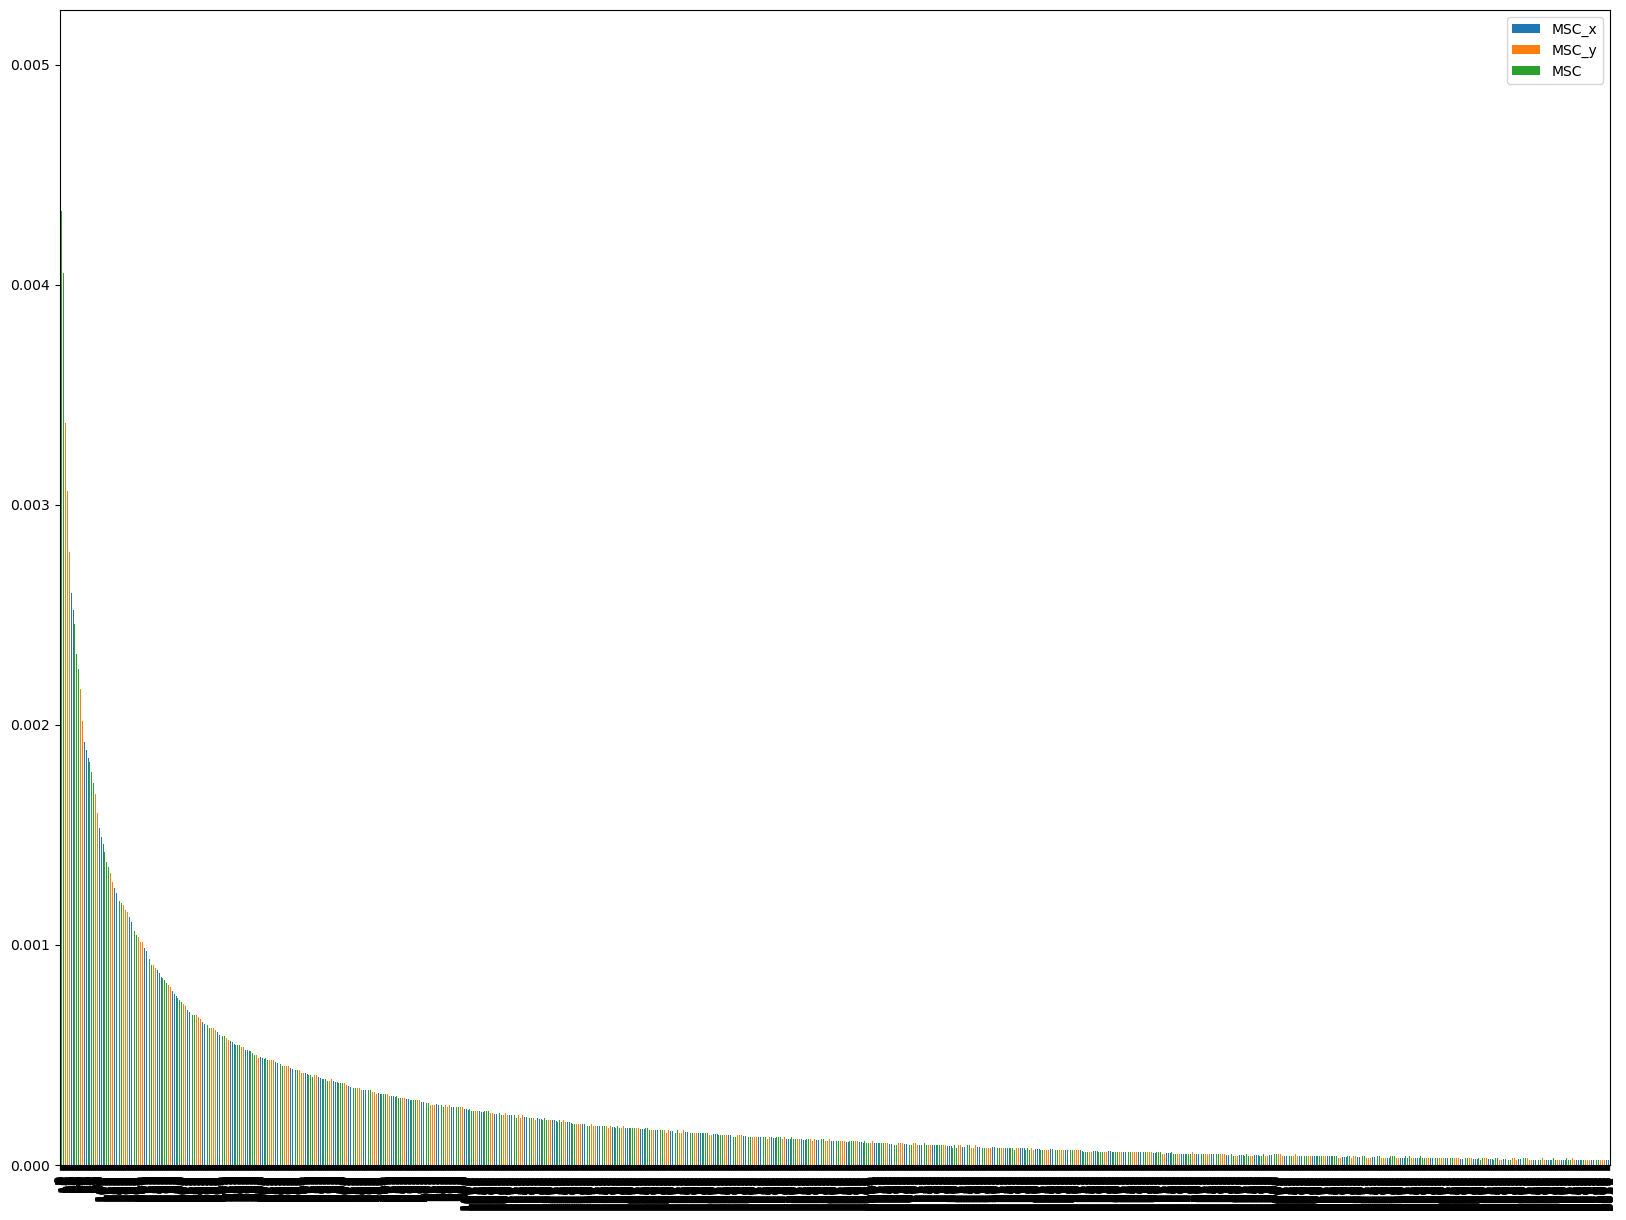

In [49]:
mark_distrib.plot(kind="bar", figsize=(20,15))

In [71]:
# combine models into dict
eval_models = {
    #"Bert+CLS": bert_cls,
    #"Bert+mp": bert_mp,
    "Bert+mp+ret_class-zbm": SentenceTransformer('./bert+mean-pooling+retrain_class_zbmath', device="cuda:0"),
    #"Bert+mp+ret_anch-arx": SentenceTransformer('./bert+mean-pooling+retrain_anchor_arxiv', device="cuda:1"),
    #"Bert+fine-tune_classi_zbm+CLS": bert_finetune_zbm_cls,
    #"Bert+fine-tune_classi_zbm+mp": bert_finetune_zbm_mp,
    #"Bert+MLM+cls": bert_mlm_cls,
    #"Bert+MLM+mp": bert_mlm_mp,
    "Bert+mlm+mp+ret_class-zbm": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath', device="cuda:0"),
    #"Bert+mlm+mp+ret_anch-arx": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_anchor_arxiv', device="cuda:1"),
    #"Bert+mlm+mp+ret_class-arx": SentenceTransformer('././bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv', device="cuda:1"),
    "Bert+tsdae-zbm+mp+ret_class-zbm_anch-arx": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_titles_zbmath+retrain_class_zbmath', device="cuda:0"),
    "Bert+tsdae-arx+mp+ret_class-zbm_anch-arx": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_class_zbmath', device="cuda:0"),
    #"Bert+mlm+mp+ret_class-zbm_anch-arx": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath_anchor_arxiv', device="cuda:1"),
    "Bert+mlm+mp+ret_anch-arx_class-zbm": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_anchor_arxiv_class_zbmath', device="cuda:0"),
    #"Bert+mlm+mp+ret_all": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv_class_zbmath_anchor_arxiv', device="cuda:1"),
    #"Bert+mlm+mp+ret_all2": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath_class_arxiv_anchor_arxiv', device="cuda:1"),
    
    #"Mathbert+CLS": mathbert_cls,
    #"Mathbert+mp": mathbert_mp,
    "Mathbert+mp+ret_class-zbm": SentenceTransformer('./mathbert+mean-pooling+retrain_class_zbmath', device="cuda:0"),
    #"Mathbert+mp+ret_anch-arx": SentenceTransformer('./mathbert+mean-pooling+retrain_anchor_arxiv', device="cuda:1"),
    #"Mathbert+mp+ret_class-arx": SentenceTransformer('./mathbert+mean-pooling+retrain_class_arxiv', device="cuda:1"),
    #"Mathbert+mp+ret_anch-arx_class-zbm": SentenceTransformer('./mathbert+mean-pooling+retrain_anchor_arxiv_class_zbmath', device="cuda:1"),
    #"Mathbert+mp+ret_class-zbm_anch-arx": SentenceTransformer('./mathbert+mean-pooling+retrain_class_zbmath_anchor_arxiv', device="cuda:1"),
    #"Mathbert+mp+ret_all": SentenceTransformer('./mathbert+mean-pooling+retrain_class_arxiv_class_zbmath_anchor_arxiv', device="cuda:1"),
    
    #"SBert": sbert,
    "SBert+ret_class-zbm": SentenceTransformer('./sbert+retrain_class_zbmath', device="cuda:0"),
    #"SBert+ret_anch-arx": SentenceTransformer('./sbert+retrain_anchor_arxiv', device="cuda:1"),
    #"SBert+ret_class-arx": SentenceTransformer('./sbert+retrain_class_arxiv', device="cuda:1"),
    #"SBert+ret_anch-arx_class-zbm": SentenceTransformer('./sbert+retrain_anchor_arxiv_class_zbmath', device="cuda:1"),
    #"SBert+ret_class-zbm_anch-arx": SentenceTransformer('./sbert+retrain_class_zbmath_anchor_arxiv', device="cuda:1"),
    #"SBert+ret_all": SentenceTransformer('./sbert+retrain_class_arxiv_class_zbmath_anchor_arxiv', device="cuda:1")
    
    "Specter 2.0+mp+class-zbm": SentenceTransformer('./specter2+mp+retrain_class_zbmath', device="cuda:0"),
    "Specter 2.0+mp+anch-arx": SentenceTransformer('./specter2+mp+retrain_anchor_arxiv', device="cuda:0"),
    
    "SGPT+class-zbm": SentenceTransformer('./gpt+retrain_class_zbmath', device="cuda:0")
}

In [7]:
def suggest(eval_models, corpus, queries, device="cuda:0", **search_args):
    msc_sug = pd.DataFrame()
    with tqdm(total=len(eval_models), desc="Models") as pb:
        for n,m in eval_models.items():
            c = torch.stack([torch.tensor(v) for v in corpus["{} ({})".format("embedding", n)].values])
            c.to(device)
            c = stu.normalize_embeddings(c)
            
            q = torch.stack([torch.tensor(v) for v in queries["{} ({})".format("embedding", n)].values])
            q.to(device)
            q = stu.normalize_embeddings(q)
            
            idxs = pd.Series([[r["corpus_id"] for r in res] for res in stu.semantic_search(q, c, score_function=stu.dot_score, **search_args)])
            msc_sug["{} ({})".format("MSC", n)] = idxs.map(lambda e: corpus.loc[e]["MSC"].values)

            pb.update()
    msc_sug.index = queries.index
    return msc_sug

In [73]:
%%time
X_test = X_test.join(suggest(eval_models, X_train, X_test, top_k=200, query_chunk_size=5000, corpus_chunk_size=500000))

Models:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 3h 14min 18s, sys: 21min 1s, total: 3h 35min 19s
Wall time: 15min 37s


In [74]:
%%time
X_eval = X_eval.join(suggest(eval_models, X_train, X_eval, top_k=200, query_chunk_size=10000, corpus_chunk_size=500000))

Models:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 1h 20min 27s, sys: 8min 23s, total: 1h 28min 50s
Wall time: 7min 18s


In [77]:
X_test.to_pickle("zbmath-200-recommendations-2000-2019-multi-test.pkl")
X_eval.to_pickle("zbmath-200-recommendations-2000-2019-multi-eval.pkl")